In [1]:
import os
import re
import nltk
from nltk import Tree

import spacy
# spacy.cli.download("nl_core_news_lg")
nlp = spacy.load("nl_core_news_lg") 

import pandas as pd
import numpy as np

import textdescriptives as td

from dataset_evaluation.utils import add_column
from dataset_evaluation.evaluation_framework import EvaluationFramework

import folia.main as folia
from pathlib import Path
from collections import defaultdict, Counter
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from datasets import load_dataset

# Datasets

In [2]:
path_name = '/Users/sabijn/Documents/PhD/Datasets/chisor_dataset_all/ChiSCor_CoNLL_paper/csv/ChiSCor_master_df_password/ChiSCor_master_df.csv'

In [3]:
df = pd.read_csv(path_name, index_col=0)
df

,id,story_lemmatized,story_raw,story_raw_no_newlines,story_no,chardepth,labels,labels_int,agegroup,treedepth_WNU,...,wbr_avg,msTTR,maTTR,MTLD,MTLD_mov,MTLD_bi,HDD,story_PP,dep_dist,agegroup_str
0,10101,er zijn er eens een meisje ze willen heel gra...,er was er eens een meisje.\nze wou heel graag ...,er was er eens een meisje. ze wou heel graag b...,1,8,person,3,5,2.166667,...,1.166667,0.975000,0.987500,37.440972,33.829268,28.065789,0.000000,1.828681,1.970588,8-9
1,10201,er zijn eens een klas en die heten de en er z...,d'r was eens een klas en die heette de Golfvis...,d'r was eens een klas en die heette de Golfvis...,1,4,agent,2,5,3.000000,...,2.142857,0.900000,0.908696,18.333333,19.781818,17.816611,0.547199,4.097504,2.285714,8-9
2,10202,er waren eens hand alleen die gaan op de comp...,d'r waren eens handen. \nalleen die gingen op ...,d'r waren eens handen. alleen die gingen op de...,2,5,agent,2,5,2.000000,...,1.500000,0.950000,0.914286,54.208000,46.756098,23.500000,0.782266,6.151254,2.256410,8-9
3,10301,er was een keer een eenhoorn en die was helem...,er was een keer een eenhoorn en die was helema...,er was een keer een eenhoorn en die was helema...,1,5,agent,2,1,2.750000,...,1.500000,0.850000,0.861290,17.792685,18.150000,14.748148,0.000000,2.713967,2.771429,4-6
4,10401,een keer naar de naar eng achtbaan toen gebeu...,een keer naar de Efteling naar enge achtbanen....,een keer naar de Efteling naar enge achtbanen....,1,3,agent,2,3,1.833333,...,1.333333,0.900000,0.940741,36.000000,30.388889,23.466667,0.000000,4.502111,2.062500,6-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,194201,mijn verhaal gaan over een cavia genaamd en w...,mijn verhaal gaat over een cavia genaamd Klaas...,mijn verhaal gaat over een cavia genaamd Klaas...,1,5,agent,2,8,2.375000,...,3.187500,0.945455,0.933945,48.265170,38.855932,36.020243,0.711542,10.583382,2.392857,11-12
615,195101,er zijn eens meisje en die was super slim ze ...,er was eens meisje en die was super slim. \nze...,er was eens meisje en die was super slim. ze z...,1,6,person,3,4,2.411765,...,3.235294,0.943750,0.952288,37.864032,37.623457,34.579255,0.721257,5.588492,2.840278,7-8
616,205101,er zijn eens een hond en die hond die was sup...,er was eens een hond. \nen die hond die was su...,er was eens een hond. en die hond die was supe...,1,6,person,3,4,2.500000,...,4.100000,0.900000,0.917273,36.528481,36.235294,31.812157,0.713953,5.594588,2.675926,7-8
617,205102,er zijn eens een meisje dat meisje heten en z...,er was eens een meisje. \ndat meisje heette El...,er was eens een meisje. dat meisje heette Elis...,2,7,person,3,4,2.588235,...,2.882353,0.943750,0.944304,31.853704,34.335329,31.661180,0.716008,6.320457,2.842105,7-8


In [4]:
tinystories = load_dataset('roneneldan/TinyStories', split='train[:1%]')

In [5]:
tinystories[5]['text']

'Once upon a time, in a big lake, there was a brown kayak. The brown kayak liked to roll in the water all day long. It was very happy when it could roll and splash in the lake.\n\nOne day, a little boy named Tim came to play with the brown kayak. Tim and the brown kayak rolled in the water together. They laughed and had a lot of fun. The sun was shining, and the water was warm.\n\nAfter a while, it was time for Tim to go home. He said goodbye to the brown kayak and gave it a big hug. The brown kayak was sad to see Tim go, but it knew they would play together again soon. So, the brown kayak kept rolling in the water, waiting for the next fun day with Tim.'

# Evaluations

Linguistic annotations
- Syntactic tree depth per sentence according to the WNU_2022 paper (van Duijn & van Dijk, 2022)
- Average no. of complements per utterance
- Sentence complexity (words before the root)
- Lexical diversity
    - msTTR (mean segmental TTR)
    - maTTR (moving average TTR)
    - MTLD (average number of words for which a consecutive TTR is maintained)
    - MTLD (moving)
    - MTLD (bidirectional)
    - HDD (bidirectional)
- Vendi score
- Dependency constrained perplexity

In [6]:
example = df.iloc[0]
eval_f = EvaluationFramework(language='nl')

## Syntatic tree depth
-- van Duijn & van Dijk (2022)

In [7]:
eval_f.add_pipe('syntactic_depth')
eval_f.run_component('syntactic_depth', example['story_raw'])


2.5

## Average no. of complements per utterance

In [8]:
eval_f.add_pipe('average_components')
eval_f.run_component('average_components', example['story_raw'])

0.3333333333333333

## Sentence complexity
-- ChiSCor (2023) - Average number of words before the root

In [9]:
eval_f.add_pipe('wbr_average')
eval_f.run_component('wbr_average', example['story_raw'])

1.1666666666666667

## Lexical diversity
-- ChiSCor (2023)

In [10]:
eval_f.add_pipe('lexical_diversity')
eval_f.run_component('lexical_diversity', example['story_lemmatized'])

{'moving_mtld': 33.829268292682926}

## Dependency distance
-- ChiSCor (2023)

In [11]:
eval_f.add_pipe('dependency_distance')
eval_f.run_component('dependency_distance', example['story_raw_no_newlines'])

1.9411764705882353

## MAUVE
-- Peeperkorn (NYP)

## Vendi score
-- [Friedman (2023) The Vendi Score: A Diversity Evaluation Metric for Machine Learning](https://github.com/vertaix/Vendi-Score)

In [12]:
from vendi_score import text_utils

# The higher, the more diversity
print(list(map(str, list(nlp(example['story_raw']).sents))))
ngram_vs = text_utils.ngram_vendi_score(list(map(str, list(nlp(example['story_raw']).sents))), ns=[1, 2])

print(f"N-grams: {ngram_vs:.02f}")


['er was er eens een meisje.\n', 'ze wou heel graag buiten spelen.\n', 'het mocht niet van haar moeder.', '\n', 'ze ging toch naar buiten en toen zei haar moeder waar ga je naartoe?', '\n', 'en het meisje zei ik ga naar buiten.\neinde.']
N-grams: 3.93


/opt/miniconda3/envs/storylmdata/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Local contextuality

## Vocabulary perplexity
-- code from ChiSCor (2023) but not published

### Load lexicon & example

In [13]:
df_lexicon = pd.read_csv('datasets/BSlexicon.csv')
df_dp_lexicon = pd.read_csv('datasets/BSdeplexicon_part.csv') # remember that this is also a partly calculated one 
df_bigram_lexicon = pd.read_csv('datasets/BSbigram_without_deps_part.csv')

example_path = Path('/Users/sabijn/Documents/PhD/Datasets/BS_only_narrative/d508835.xml')
ex_doc = folia.Document(file=str(example_path))
ex_enriched = nlp(ex_doc.text())

### Perplexity

In [14]:
 #-- adding vocabulary perplexity
def extract_PP(story, lexicon):
    bs_sum = lexicon['freq'].sum()

    story_df = pd.DataFrame([(w.lemma_, re.search(r'^\w+', w.tag_).group(0)) for w in nlp(story) if w.is_alpha if w.lemma_ != 'PROPN'], columns=['lemma', 'pos'])
    print(story_df)
    # find match with the lexicon
    story_df = pd.merge(story_df, lexicon, how='left', on=['lemma', 'pos'])
    story_df = story_df[['lemma', 'pos', 'freq']]

    # remove NaNs/duplicate rows
    story_df.dropna(subset=['freq'], inplace=True)
    story_df.drop_duplicates(inplace=True)

    # container for log probabilities
    probs = []

    # take MLEs and calculate logprobs
    for _, row in story_df.iterrows():
        c = row['freq']
        p = np.log(c/bs_sum)
        probs.append(p)

    # turn probs into series
    probs = pd.Series(probs)

    # calculating PP
    normalized_probs = np.exp((probs.sum() / len(probs)))

    # transforming so that not all values are that extreme / 100
    return (1 / normalized_probs) / 100

#extract_PP(example['story_raw'], df_lexicon)
# add_column('story_raw', 'story_PP', extract_PP, df)

In [15]:
def extract_PP_bigram(story, lexicon):
    bs_sum = lexicon['freq'].sum()

    story_lexicon = defaultdict(int)
    
    enriched_doc = nlp(story)
    for i in range(len(enriched_doc) - 1):
        story_lexicon[(enriched_doc[i].lemma_, enriched_doc[i + 1].lemma_)] += 1
    
    story_df = pd.DataFrame(story_lexicon.keys(),
        columns=['lemma1', 'lemma2'])

    story_df = pd.merge(story_df, lexicon, how='left', on=['lemma1', 'lemma2'])
    story_df = story_df[['lemma1', 'lemma2', 'freq']]

    # remove NaNs/duplicate rows
    story_df.fillna({'freq': 1}, inplace=True)
    story_df.drop_duplicates(inplace=True)

    # container for log probabilities
    probs = []

    # take MLEs and calculate logprobs
    for _, row in story_df.iterrows():
        c = row['freq']
        p = np.log(c/bs_sum)
        probs.append(p)

    # turn probs into series
    probs = pd.Series(probs)
    
    # calculating PP
    try:
        normalized_probs = np.exp((probs.sum() / len(probs)))
        # transforming so that not all values are that extreme / 100
        return (1 / normalized_probs) / 100
    except:
        print('No probabilities found, inspect')
        return None

#extract_PP_bigram(example['story_raw_no_newlines'], df_bigram_lexicon)

In [50]:
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_
    

def select_dep_pairs(node, selected):
    temp = {child.dep_ : child for child in list(node.children)}

    if node.dep_ in ['ROOT', 'ccomp', 'xcomp', 'conj']:
        for (child_dep, child) in temp.items():
            if child_dep in ['nsubj', 'obj', 'cop', 'nsubj:pass'] and child.pos_ != 'PRON' and child.text != 'einde':
                selected[((str(child.lemma_), str(node.lemma_)), (child_dep, node.dep_))] += 1
    
    if node.pos_ == 'NOUN':
        for child in list(node.children):
            if child.pos_ == 'ADJ' and child.dep_ == 'amod':
                selected[((str(child.lemma_), str(node.lemma_)), (child.dep_, node.dep_))] += 1

    if node.n_lefts + node.n_rights > 0:
        for child in node.children:
            select_dep_pairs(child, selected=selected)

    return selected

story = df.iloc[1]

print(story['story_raw'])
pair_dict = defaultdict(int)
for sentence in list(nlp(story['story_raw']).sents):
    pair_dict = select_dep_pairs(sentence.root, pair_dict)
    #to_nltk_tree(sentence.root).pretty_print()
    
pair_dict

d'r was eens een klas en die heette de Golfvis. 
en er was eens een juffrouw die heette Mariëlle. 
Mariëlle ging toen TV kijken. 
op de TV was een TV. 
daar keek Mariëlle naar de TV. 
op de TV passen maar vier keek Mariëlle naar de TV op die TV. 
en toen gingen ze tellen alleen maar door en toen zagen ze vijftig Mariëlles die naar de TV keken.


defaultdict(int,
            {(('zijn', 'klas'), ('cop', 'ROOT')): 1,
             (('Golfvis', 'heten'), ('obj', 'conj')): 1,
             (('juffrouw', 'zijn'), ('nsubj', 'conj')): 1,
             (('Mariëlle', 'gaan'), ('nsubj', 'ROOT')): 1,
             (('Mariëlle', 'kijken'), ('nsubj', 'conj')): 1,
             (('Mariëlles', 'zien'), ('obj', 'conj')): 1})

In [ ]:
def extract_PP_constrained(story, lexicon, output_pairs=False):
    bs_sum = lexicon['freq'].sum()

    story_lexicon = defaultdict(int)
    for sent in nlp(story).sents:
        story_lexicon = select_dep_pairs(sent.root, story_lexicon)

    story_df = pd.DataFrame([str(k[0]) for k in story_lexicon.keys()],
        columns=['lemma'])

    lexicon_without_pos = lexicon[['lemma', 'freq']]
    story_df = pd.merge(story_df, lexicon_without_pos, how='left', on=['lemma'])
    story_df = story_df[['lemma', 'freq']]

    # remove NaNs/duplicate rows
    story_df.fillna({'freq': 1}, inplace=True)
    story_df.drop_duplicates(inplace=True)
    story_df.to_csv('test.csv')


    probs = []
    # take MLEs and calculate logprobs
    for _, row in story_df.iterrows():
        c = row['freq']
        p = np.log(c/bs_sum)
        probs.append(p)

    # turn probs into series
    probs = pd.Series(probs)
    
    # calculating PP
    try:
        normalized_probs = np.exp((probs.sum() / len(probs)))

        if not output_pairs:
            # transforming so that not all values are that extreme / 100
            return (1 / normalized_probs) / 100
        else:
            return (1 / normalized_probs) / 100, story_df
        
    except ZeroDivisionError:
        print('***** No probabilities found, inspect *******')
        print(story)
        print(f'{story_lexicon}')
        for token in nlp(story):
            print(f'{token.lemma_} {token.pos_} {token.dep_}')
            
        return None

In [52]:
def extract_PP_constrained_without_pos(story, lexicon, output_pairs=False):
    bs_sum = lexicon['freq'].sum()

    story_lexicon = defaultdict(int)
    for sent in nlp(story).sents:
        story_lexicon = select_dep_pairs(sent.root, story_lexicon)

    story_df = pd.DataFrame(story_lexicon.keys(),
        columns=['lemma1', 'lemma2'])

    story_df = pd.merge(story_df, lexicon, how='left', on=['lemma1', 'lemma2'])
    story_df = story_df[['lemma1', 'lemma2', 'freq']]

    # remove NaNs/duplicate rows
    story_df.fillna({'freq': 1}, inplace=True)
    story_df.drop_duplicates(inplace=True)

    probs = []
    # take MLEs and calculate logprobs
    for _, row in story_df.iterrows():
        c = row['freq']
        p = np.log(c/bs_sum)
        probs.append(p)

    # turn probs into series
    probs = pd.Series(probs)
    
    # calculating PP
    try:
        normalized_probs = np.exp((probs.sum() / len(probs)))

        if not output_pairs:
            # transforming so that not all values are that extreme / 100
            return (1 / normalized_probs) / 100
        else:
            return (1 / normalized_probs) / 100, story_df
        
    except ZeroDivisionError:
        print('***** No probabilities found, inspect *******')
        print(story)
        print(f'{story_lexicon}')
        for token in nlp(story):
            print(f'{token.lemma_} {token.pos_} {token.dep_}')
            
        return None

In [18]:
df['story_PP_dep'] = df.apply(lambda row: extract_PP_constrained(row['story_raw'], df_dp_lexicon), axis = 1) 

***** No probabilities found, inspect *******
ik wou dat ik op een babydraak zat.
defaultdict(<class 'int'>, {})
ik PRON nsubj
willen VERB ROOT
dat SCONJ mark
ik PRON nsubj
op ADP case
een DET det
babydraak NOUN obl
zitten VERB ccomp
. PUNCT punct
***** No probabilities found, inspect *******
ik werkte bij de brandweer een jaar lang.
en toen was ik met pensioen.
en ik had een feest.
en het was bij een kermis.
einde.
defaultdict(<class 'int'>, {})
ik PRON nsubj
werken VERB ROOT
bij ADP case
de DET det
brandweer NOUN obl
een DET det
jaar NOUN obl
lang ADJ obl
. PUNCT punct

 SPACE dep
en CCONJ cc
toen ADV advmod
zijn AUX conj
ik PRON nsubj
met ADP case
pensioen NOUN obl
. PUNCT punct

 SPACE dep
en CCONJ cc
ik PRON nsubj
hebben VERB ROOT
een DET det
feest NOUN obj
. PUNCT punct

 SPACE dep
en CCONJ cc
het PRON nsubj
zijn AUX conj
bij ADP case
een DET det
kermis NOUN obl
. PUNCT punct

 SPACE dep
einde NOUN obj
. PUNCT punct
***** No probabilities found, inspect *******
ik mag niet nou no

In [ ]:
df['story_PP_bigram'] = df.apply(lambda row: extract_PP_bigram(row['story_raw'], df_bigram_lexicon), axis = 1)  

In [53]:
df_dp_zonder_lexicon = pd.read_csv('datasets/BSdep_without_deps_part.csv')
df['story_PP_dep_new'] = df.apply(lambda row: extract_PP_constrained_without_pos(row['story_raw'], df_dp_zonder_lexicon), axis = 1)

***** No probabilities found, inspect *******
ik wou dat ik op een babydraak zat.
defaultdict(<class 'int'>, {})
ik PRON nsubj
willen VERB ROOT
dat SCONJ mark
ik PRON nsubj
op ADP case
een DET det
babydraak NOUN obl
zitten VERB ccomp
. PUNCT punct
***** No probabilities found, inspect *******
ik werkte bij de brandweer een jaar lang.
en toen was ik met pensioen.
en ik had een feest.
en het was bij een kermis.
einde.
defaultdict(<class 'int'>, {})
ik PRON nsubj
werken VERB ROOT
bij ADP case
de DET det
brandweer NOUN obl
een DET det
jaar NOUN obl
lang ADJ obl
. PUNCT punct

 SPACE dep
en CCONJ cc
toen ADV advmod
zijn AUX conj
ik PRON nsubj
met ADP case
pensioen NOUN obl
. PUNCT punct

 SPACE dep
en CCONJ cc
ik PRON nsubj
hebben VERB ROOT
een DET det
feest NOUN obj
. PUNCT punct

 SPACE dep
en CCONJ cc
het PRON nsubj
zijn AUX conj
bij ADP case
een DET det
kermis NOUN obl
. PUNCT punct

 SPACE dep
einde NOUN obj
. PUNCT punct
***** No probabilities found, inspect *******
ik mag niet nou no

### Plotting and investigating

In [32]:
def plot_pp_histogram(data, binsize=30, figure_size=(8,6), title='Dependency-constraint perplexities'):
    plt.figure(figsize=figure_size)
    plt.hist(data, bins=binsize, edgecolor='black')
    plt.title(title)
    plt.xlabel('Perplexity')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

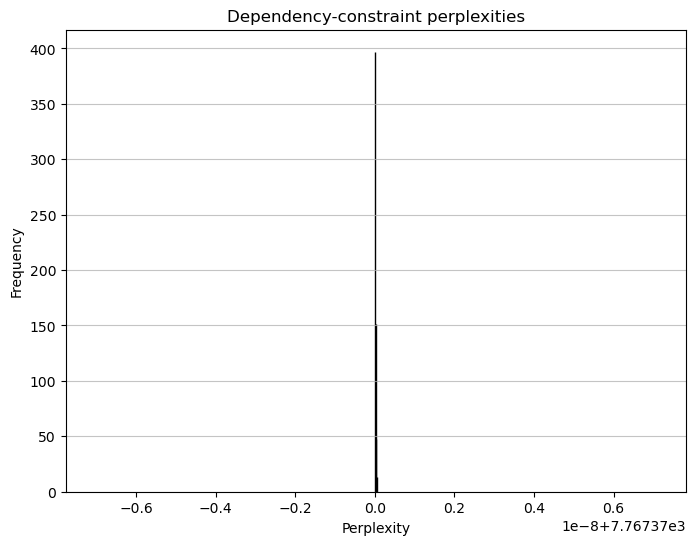

In [54]:
# Plot histogram
plot_pp_histogram(df['story_PP_dep_new'])

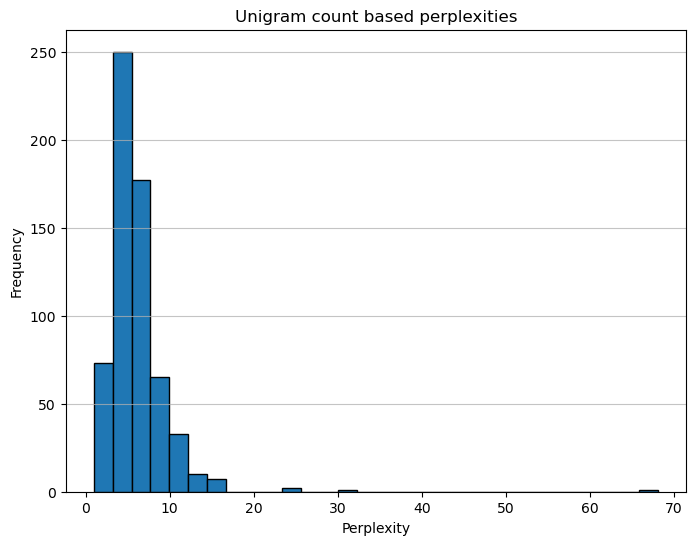

In [33]:
plot_pp_histogram(df['story_PP'], title='Unigram count based perplexities')

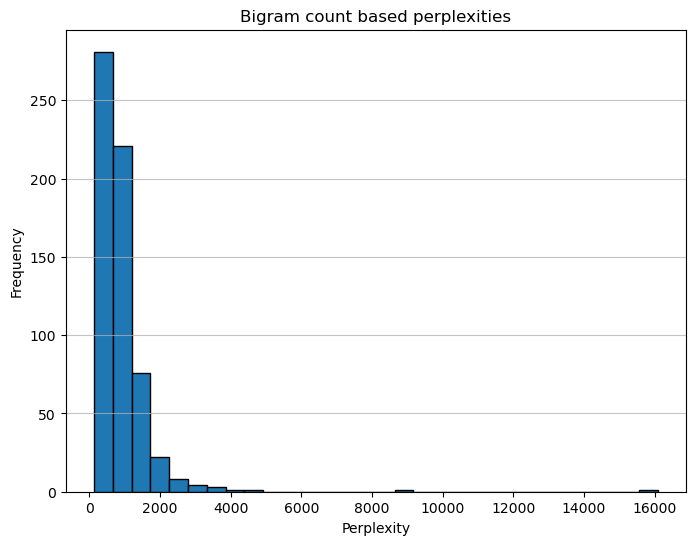

In [34]:
plot_pp_histogram(df['story_PP_bigram'], title='Bigram count based perplexities')

In [41]:
high_pp_dep_idx = df.index[(df['story_PP_dep'] > 5300) & (df['story_PP_dep'] < 7000)].tolist()
high_pp_uni_idx = df.index[df['story_PP'] > 20].tolist()
high_pp_bi_idx = df.index[df['story_PP_bigram'] > 3000].tolist()

In [47]:
print('*' * 100)
print(f'Dependency constrained perplexity ({len(high_pp_dep_idx)})')
for idx in high_pp_dep_idx:
    print('-' * 50)
    print(df.iloc[idx]['story_PP_dep'])
    print(df.iloc[idx]['story_raw'])
    print(extract_PP_constrained(df.iloc[idx]['story_raw'], df_dp_lexicon, output_pairs=True)[1])


# print('*' * 100)
# print(f'Unigram perplexity ({len(high_pp_uni_idx)})')
# for idx in high_pp_uni_idx:
#     print('-' * 50)
#     print(df.iloc[idx]['story_PP'])
#     print(df.iloc[idx]['story_raw'])

# print('*' * 100)
# print(f'Bigram perplexity ({len(high_pp_bi_idx)})')
# for idx in high_pp_bi_idx:
#     print('-' * 50)
#     print(df.iloc[idx]['story_PP_bigram'])
#     print(df.iloc[idx]['story_raw'])

****************************************************************************************************
Dependency constrained perplexity (14)
--------------------------------------------------
6164.965654513117
een keer naar de Efteling naar enge achtbanen. 
toen gebeurde er zo ik ging naar de.
ik weet niet meer welke achtbaan.
de Python.
en daarna ging ik gewoon op de kop twee keer. 
en dat was bij Rotterdam.
                   lemma  freq
0     ('eng', 'achtban')     2
1     ('eng', 'achtban')     1
2  ('achtbaan', 'weten')     1
--------------------------------------------------
5492.359998984962
er was eens één sok. 
die sok ging uit de kast. 
en die liep dus toen ging die naar beneden. 
en toen ging iemand hem pakken. 
en toen werd hij boos op die sok.
             lemma  freq
0  ('sok', 'zijn')     2
1  ('sok', 'gaan')     1
--------------------------------------------------
5886.5656936079395
d'r was een politie en die zei.
en d'r waren honderd boeven en die zeiden.
en ze waren al

### Perplexity constrained tinystories dutch

In [23]:
example_1 = 'Er was eens een autootje dat Beep heette. Beep hield ervan om hard te rijden en in de zon te spelen. Beep was een gezonde auto omdat hij altijd goede brandstof had. Goede brandstof maakte Beep blij en sterk.\n\nOp een dag reed Beep in het park toen hij een grote boom zag. De boom had veel bladeren die vielen. Beep vond het leuk hoe de bladeren vielen en wilde ermee spelen. Beep reed onder de boom door en keek hoe de bladeren op hem vielen. Hij lachte en toeterde.\n\nBeep speelde de hele dag met de vallende bladeren. Toen het tijd was om naar huis te gaan, wist Beep dat hij meer brandstof nodig had. Hij ging naar de tankstation en haalde meer gezonde brandstof. Nu was Beep klaar om hard te rijden en de volgende dag weer te spelen. En Beep leefde nog lang en gelukkig.'
example_2 = 'Op een dag zwom er een visje genaamd Fin langs de kust. Hij zag een grote krab en wilde vriendjes worden. "Hoi, ik ben Fin. Wil je spelen?" vroeg het visje. De krab keek Fin aan en zei: "Nee, ik wil niet spelen. Ik heb het koud en ik voel me niet lekker." Fin voelde zich verdrietig, maar wilde de krab helpen zich beter te voelen. Hij zwom weg en bedacht een plan. Hij herinnerde zich dat de zon dingen warm kon maken. Dus zwom Fin naar de oppervlakte en riep naar de zon: "Alsjeblieft, zon, zorg ervoor dat mijn nieuwe vriend zich beter voelt en niet bevriest!" De zon hoorde Fins roep en scheen zijn warme licht op de kust. De krab begon zich beter te voelen en was niet meer zo koud. Hij zag Fin en zei: "Dankjewel, visje, dat je me een goed gevoel geeft. Ik heb niet het gevoel dat ik nu ga bevriezen. Laten we samen spelen!" En zo speelden Fin en de krab en werden goede vrienden.'
example_3 = 'Er was eens, in een land vol bomen, een kleine kersenboom. De kersenboom was erg verdrietig omdat hij geen vrienden had. Alle andere bomen waren groot en sterk, maar de kersenboom was klein en zwak. De kersenboom was jaloers op de grote bomen.\n\nOp een dag voelde de kersenboom een kriebel in zijn takken. Het was een zacht lentewindje. De wind vertelde de kersenboom dat hij niet verdrietig moest zijn. De wind zei: "Je bent bijzonder omdat je zoete kersen hebt waar iedereen dol op is." De kersenboom begon zich iets beter te voelen.\n\nNaarmate de tijd verstreek, groeiden er steeds meer kersen aan de kersenboom. Alle dieren in het land kwamen de kersen eten en onder de kersenboom spelen. De kersenboom was blij omdat hij nu veel vrienden had. De kersenboom leerde dat anders zijn iets goeds kan zijn. En ze leefden nog lang en gelukkig.'
example_4 = 'Er was eens een klein meisje dat Lily heette. Lily deed graag alsof ze een populaire prinses was. Ze woonde in een groot kasteel met haar beste vriendinnen, een kat en een hond.\n\nOp een dag, terwijl ze in het kasteel speelde, vond Lily een groot spinnenweb. Het spinnenweb zat in de weg van haar leuke spelletje. Ze wilde ervan af, maar ze was bang voor de spin die erin leefde.\n\nLily vroeg haar vriendinnen, de kat en de hond, om haar te helpen. Ze werkten allemaal samen om het spinnenweb schoon te maken. De spin was verdrietig, maar vond buiten een nieuw thuis. Lily, de kat en de hond waren blij dat ze konden spelen zonder dat het spinnenweb in de weg zat. En ze leefden nog lang en gelukkig.'
example_5 = 'Er was eens, in een groot meer, een bruine kajak. De bruine kajak rolde de hele dag door het water. Hij was erg blij als hij kon rollen en spetteren in het meer.\n\nOp een dag kwam een jongetje genaamd Tim met de bruine kajak spelen. Tim en de bruine kajak rolden samen door het water. Ze lachten en hadden veel plezier. De zon scheen en het water was warm.\n\nNa een tijdje was het tijd voor Tim om naar huis te gaan. Hij nam afscheid van de bruine kajak en gaf hem een dikke knuffel. De bruine kajak was verdrietig om Tim te zien gaan, maar hij wist dat ze snel weer samen zouden spelen. Dus bleef de bruine kajak door het water rollen, wachtend op de volgende leuke dag met Tim.'

In [24]:
examples = [example_1, example_2, example_3, example_4, example_5]
for e in examples:
    print('----------------')
    print(e)
    print(extract_PP_constrained(e, df_dp_lexicon))

----------------
Er was eens een autootje dat Beep heette. Beep hield ervan om hard te rijden en in de zon te spelen. Beep was een gezonde auto omdat hij altijd goede brandstof had. Goede brandstof maakte Beep blij en sterk.

Op een dag reed Beep in het park toen hij een grote boom zag. De boom had veel bladeren die vielen. Beep vond het leuk hoe de bladeren vielen en wilde ermee spelen. Beep reed onder de boom door en keek hoe de bladeren op hem vielen. Hij lachte en toeterde.

Beep speelde de hele dag met de vallende bladeren. Toen het tijd was om naar huis te gaan, wist Beep dat hij meer brandstof nodig had. Hij ging naar de tankstation en haalde meer gezonde brandstof. Nu was Beep klaar om hard te rijden en de volgende dag weer te spelen. En Beep leefde nog lang en gelukkig.
1327.2154002727575
----------------
Op een dag zwom er een visje genaamd Fin langs de kust. Hij zag een grote krab en wilde vriendjes worden. "Hoi, ik ben Fin. Wil je spelen?" vroeg het visje. De krab keek Fin 

## Past tense use

In [25]:
def percentage_past_tense(story):
    tense = Counter([token.morph.to_dict()['Tense'] for token in nlp(story).doc if 'Tense' in token.morph.to_dict().keys()])

    try:
        return tense['Past'] / (tense['Past'] + tense['Pres'])
    except:
        return None

In [26]:
story = df.iloc[9]['story_raw']

percentage_past_tense(story)

0.8125

In [27]:
for e in examples:
    print(percentage_past_tense(e))

1.0
0.6060606060606061
0.7916666666666666
1.0
0.9444444444444444


In [28]:
df['story_past_tense'] = df.apply(lambda row: percentage_past_tense(row['story_raw']), axis = 1) 

In [29]:
def plot_percentages(data, binsize=30, figure_size=(8,6)):
    plt.figure(figsize=figure_size)
    plt.hist(data, bins=binsize, edgecolor='black')
    plt.title('Past tense use')
    plt.xlabel('Percentages')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

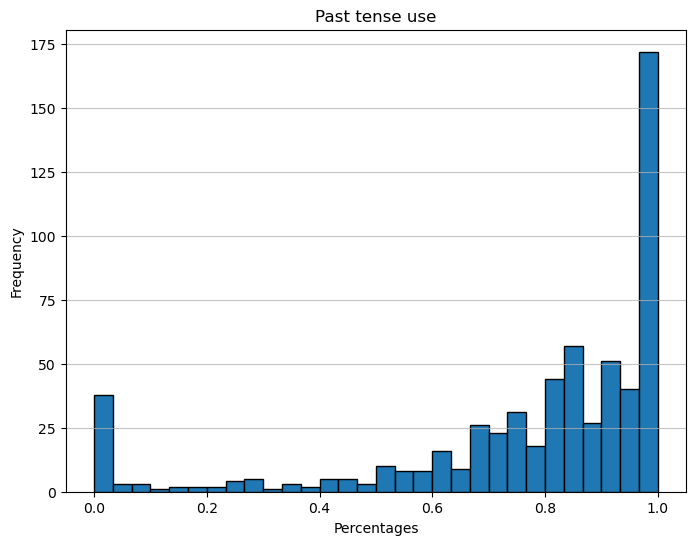

In [30]:
plot_percentages(df['story_past_tense'])

In [58]:
for sent in ex_enriched:
    print(dir(sent))
    break

['_', '__bytes__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', 'ancestors', 'check_flag', 'children', 'cluster', 'conjuncts', 'dep', 'dep_', 'doc', 'ent_id', 'ent_id_', 'ent_iob', 'ent_iob_', 'ent_kb_id', 'ent_kb_id_', 'ent_type', 'ent_type_', 'get_extension', 'has_dep', 'has_extension', 'has_head', 'has_morph', 'has_vector', 'head', 'i', 'idx', 'iob_strings', 'is_alpha', 'is_ancestor', 'is_ascii', 'is_bracket', 'is_currency', 'is_digit', 'is_left_punct', 'is_lower', 'is_oov', 'is_punct', 'is_quote', 'is_right_punct', 'is_sent_end', 'is_sent_start', 'is_space', 'is_stop', 'is_title', 'is_upper', 'lang', 'lang_', 'left_edge', 'lefts', 'lemma', 'lemma_', 'lex', 'lex_id', 'li

## Grammaticality

$G(story) = \dfrac{\sum^k_{i=1}(G(s_i))}{k}$, with $s$ a sentence in the story.  
  
$G(sentence) = P(seq) = \log(\sqrt[n]{\prod_{i=1}^n \left( P(K_i) \right)})$.  
  
$P(K_i) = P(t_3t_2t_1) = \lambda_1 \cdot P(t_3|t_1t_2) + \lambda_2 \cdot P(t_3|t_2) + \lambda_3 \cdot P(t_3)$, where  
  
- where $\lambda_1 + \lambda_2 + \lambda_3 = 1$, ($\lambda_1 = 0.5, \lambda_2 = 0.3, \lambda_3 = 0.2 \rightarrow$ vadlapudi (2010))
- $P(t_3|t_1t_2) = \dfrac{f(t_1t_2t_3)}{f(t_1t_2)}$.  
- $P(t_3|t_2) = \dfrac{f(t_2t_3)}{f(t_2)}$.  
- $P(t_3) = \dfrac{f(t_3)}{\sum_{\forall t_i} f(t_i)}$


In [67]:
import math

class Grammaticality():
    L1, L2, L3 = 0.5, 0.3, 0.2       
    MIN_PROB = 1e-12

    def __init__(self, nlp, unigram_csv, bigram_csv, trigram_csv):
        self.nlp = nlp
        self.unigram, self.bigram, self.trigram, self.total_u = self._load_counts(unigram_csv, bigram_csv, trigram_csv)

    # ---------- Load counts ----------
    def _load_counts(self, unigram_csv, bigram_csv, trigram_csv):
        # Unigrams: columns ['pos', 'freq']
        df_u = pd.read_csv(unigram_csv)
        unigram = Counter(dict(zip(df_u["pos"], df_u["freq"])))

        # Bigrams: columns ['pos1','pos2','freq'] meaning (t2, t3)
        df_b = pd.read_csv(bigram_csv)
        bigram = Counter({(r.pos1, r.pos2): int(r.freq) for r in df_b.itertuples(index=False)})

        # Trigrams: columns ['pos1','pos2','pos3','freq'] meaning (t1, t2, t3)
        df_t = pd.read_csv(trigram_csv)
        trigram = Counter({(r.pos1, r.pos2, r.pos3): int(r.freq) for r in df_t.itertuples(index=False)})

        total_unigrams = sum(unigram.values())

        return unigram, bigram, trigram, total_unigrams
    
    # ---------- Probability helpers ----------
    @staticmethod
    def _frac(num: int, den: int) -> float:
        return (num / den) if den > 0 else 0.0

    def _p_unigram(self, t3: str) -> float:
        # NOTE: the original formula had a small typo; it should be f(t3)/sum_i f(t_i)
        return self._frac(self.unigram.get(t3, 0), self.total_u)

    def _p_bigram(self, t2: str, t3: str) -> float:
        return self._frac(self.bigram.get((t2, t3), 0), self.unigram.get(t2, 0))

    def _p_trigram(self, t1: str, t2: str, t3: str) -> float:
        return self._frac(self.trigram.get((t1, t2, t3), 0), self.bigram.get((t1, t2), 0))

    def _p_interpolated(self, t1: str, t2: str, t3: str) -> float:
        # λ1 * P(t3|t1,t2) + λ2 * P(t3|t2) + λ3 * P(t3)
        p = self.L1 * self._p_trigram(t1, t2, t3) + self.L2 * self._p_bigram(t2, t3) + self.L3 * self._p_unigram(t3)
        return max(p, self.MIN_PROB)  # floor to avoid log(0)

    def _pos_tags(self, text: str):
        """Return list of lists of POS tags for each sentence."""
        doc = nlp(text)
        sents = []
        for sent in doc.sents:
            tags = [t.pos_ for t in sent if not t.is_space]
            if tags:
                sents.append(tags)
        return sents
    
    def _score_sentence(self, tags):
        """
        G(sentence) = (1/n) * sum_{i=1..n} log P(K_i)
        For K_i, we use (t_{i-2}, t_{i-1}, t_i). For i < 3, we degrade context gracefully.
        """
        n = len(tags)
        if n == 0:
            return float("-inf")

        log_sum = 0.0
        for i, t3 in enumerate(tags):
            t2 = tags[i-1] if i-1 >= 0 else None
            t1 = tags[i-2] if i-2 >= 0 else None

            if t1 is None and t2 is None:
                # only unigram available
                p = self._p_unigram(t3)
            elif t1 is None:
                # bigram + unigram
                p = self.L2 * self._p_bigram(t2, t3) + self.L3 * self._p_unigram(t3)
                p = max(p, self.MIN_PROB)
            else:
                p = self._p_interpolated(t1, t2, t3)

            log_sum += math.log(p)

        return log_sum / n  # average log-prob (log of geometric mean)

    def _score_story(self, text: str):
        """
        G(story) = average of G(sentence) over all sentences in the text.
        Returns (G_story, per_sentence_scores, per_sentence_tags)
        """
        sentences = self._pos_tags(text)
        if not sentences:
            return float("-inf"), [], []

        scores = [self._score_sentence(tags) for tags in sentences]
        g_story = sum(scores) / len(scores)
        return g_story, scores, sentences 

    def evaluate(self, text: str) -> float:
        return self._score_story(text)

In [ ]:
# ---------- Config ----------
u_csv = Path('/Users/sabijn/Documents/PhD/code/storylm_p1_data/datasets/BS_unigrams_part.csv')
b_csv  = Path('/Users/sabijn/Documents/PhD/code/storylm_p1_data/datasets/BS_bigrams_part.csv')
t_csv = Path('/Users/sabijn/Documents/PhD/code/storylm_p1_data/datasets/BS_trigrams_part.csv')

GramScore = Grammaticality(nlp, u_csv, b_csv, t_csv)

g_story, per_sent, per_tags = GramScore.evaluate(example['story_raw'])
print("G(story):", g_story)
for i, (s, tags) in enumerate(zip(per_sent, per_tags), 1):
    print(f"  G(sentence {i}): {s:.6f}  |  tags: {tags}")

G(story): -2.044148074962318
  G(sentence 1): -1.932699  |  tags: ['ADV', 'VERB', 'ADV', 'ADV', 'DET', 'NOUN', 'PUNCT']
  G(sentence 2): -2.178245  |  tags: ['PRON', 'VERB', 'ADJ', 'ADV', 'ADP', 'VERB', 'PUNCT']
  G(sentence 3): -1.916297  |  tags: ['PRON', 'AUX', 'ADV', 'ADP', 'PRON', 'NOUN', 'PUNCT']
  G(sentence 4): -2.061849  |  tags: ['PRON', 'VERB', 'ADV', 'ADP', 'ADP', 'CCONJ', 'ADV', 'VERB', 'PRON', 'NOUN', 'ADV', 'VERB', 'PRON', 'ADP', 'PUNCT']
  G(sentence 5): -2.131651  |  tags: ['CCONJ', 'DET', 'NOUN', 'VERB', 'PRON', 'VERB', 'ADP', 'ADP', 'PUNCT', 'NOUN', 'PUNCT']


In [69]:
df['story_grammaticality'] = df.apply(lambda row: GramScore.evaluate(row['story_raw']), axis = 1) 

In [70]:
def plot_histogram(data, binsize=30, figure_size=(8,6), title='Dependency-constraint perplexities', xlabel='Perplexity', ylabel='Frequency'):
    plt.figure(figsize=figure_size)
    plt.hist(data, bins=binsize, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.75)

In [ ]:
plot_